In [20]:
# Import our dependencies
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
import hvplot.pandas
import psycopg2
import config
from config import db_pw

In [21]:
#establishing the connection
conn = psycopg2.connect(
   database="Predictive_Senescence_DB", user='postgres', password= db_pw, host='predictive-senescence-db.cbunnafql9ym.us-east-2.rds.amazonaws.com', port= '5432'
)

#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Retrieving data
cursor.execute('''SELECT * from birds_data_raw''')

#Fetching 1st row from the table
df = pd.DataFrame(cursor.fetchall(), columns=["Collection_Num", "BirdID", "Sex", "AgeY", "AgeClass", "BirthFPID", "U_PlateID", "RTL", "Technician", "Terr", "FPID", 'mum', 'dad', "MAC", 'PAC','BrF', 'BrM']);
print(df)

#Commit your changes in the database
conn.commit()

#Closing the connection
conn.close()

      Collection_Num  BirdID  Sex       AgeY AgeClass  BirthFPID U_PlateID  \
0                  1    5511    0   0.246575        J        103       9_3   
1                  2    5559    1   3.597260        A        103       9_1   
2                  3    5559    1   4.715068        A        103      9_28   
3                  4    5559    1   0.657534       SA        103       9_2   
4                  5    5527    1   0.328767      OFL        103       9_3   
...              ...     ...  ...        ...      ...        ...       ...   
2657            2658     221    1   6.958904        A          8       2_1   
2658            2659     216    1   8.947945        A          8       8_8   
2659            2660     176    1   6.772603        A          8      7_32   
2660            2661     221    1   9.090411        A          8      1_12   
2661            2662     176    1  13.873973        A          8       4_3   

       RTL  Technician   Terr  FPID   mum   dad       MAC      

In [22]:
# Generate our categorical variable list
df_cat = df.dtypes[df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
df[df_cat].nunique()

AgeClass       6
U_PlateID    271
dtype: int64

In [23]:
# Check the unique value counts to see if binning is required
df.AgeY.value_counts()

0.657534     212
0.328767     162
0.164384     144
1.000000      96
0.027397      87
            ... 
0.326027       1
3.054795       1
4.465753       1
10.890411      1
13.873973      1
Name: AgeY, Length: 1262, dtype: int64

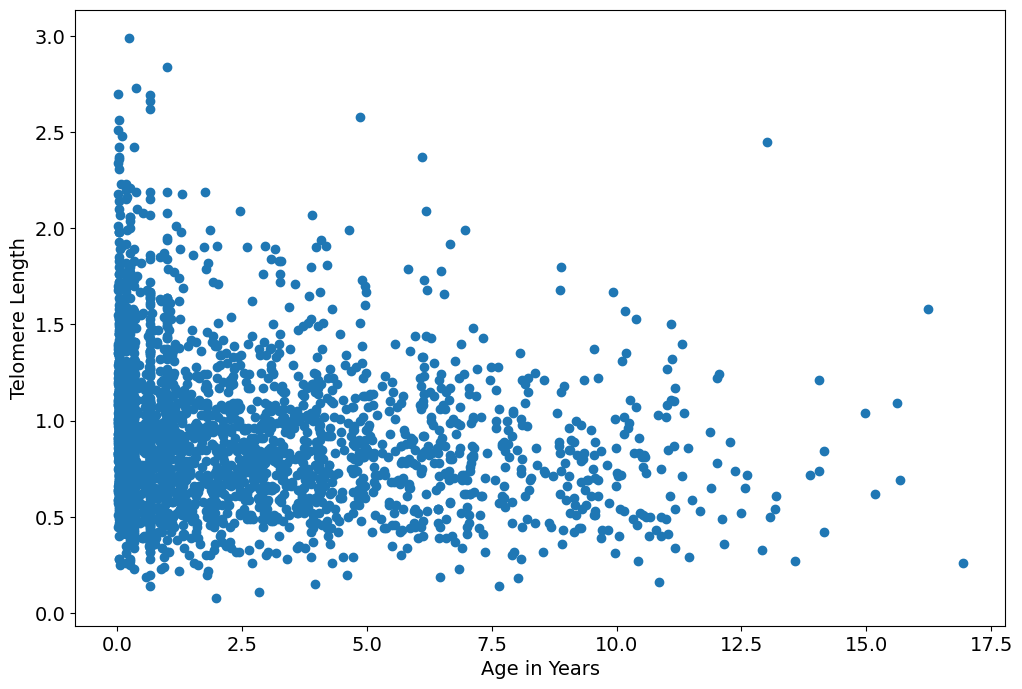

In [24]:
# scatterplot of Age in Yeras and Telomere length
import matplotlib.pyplot as plt
fig = plt.figure()
plt.scatter(df.AgeY, df.RTL)
plt.xlabel('Age in Years')
plt.ylabel('Telomere Length')
plt.show()
#fig.savefig('ScattAgeTelo.png')


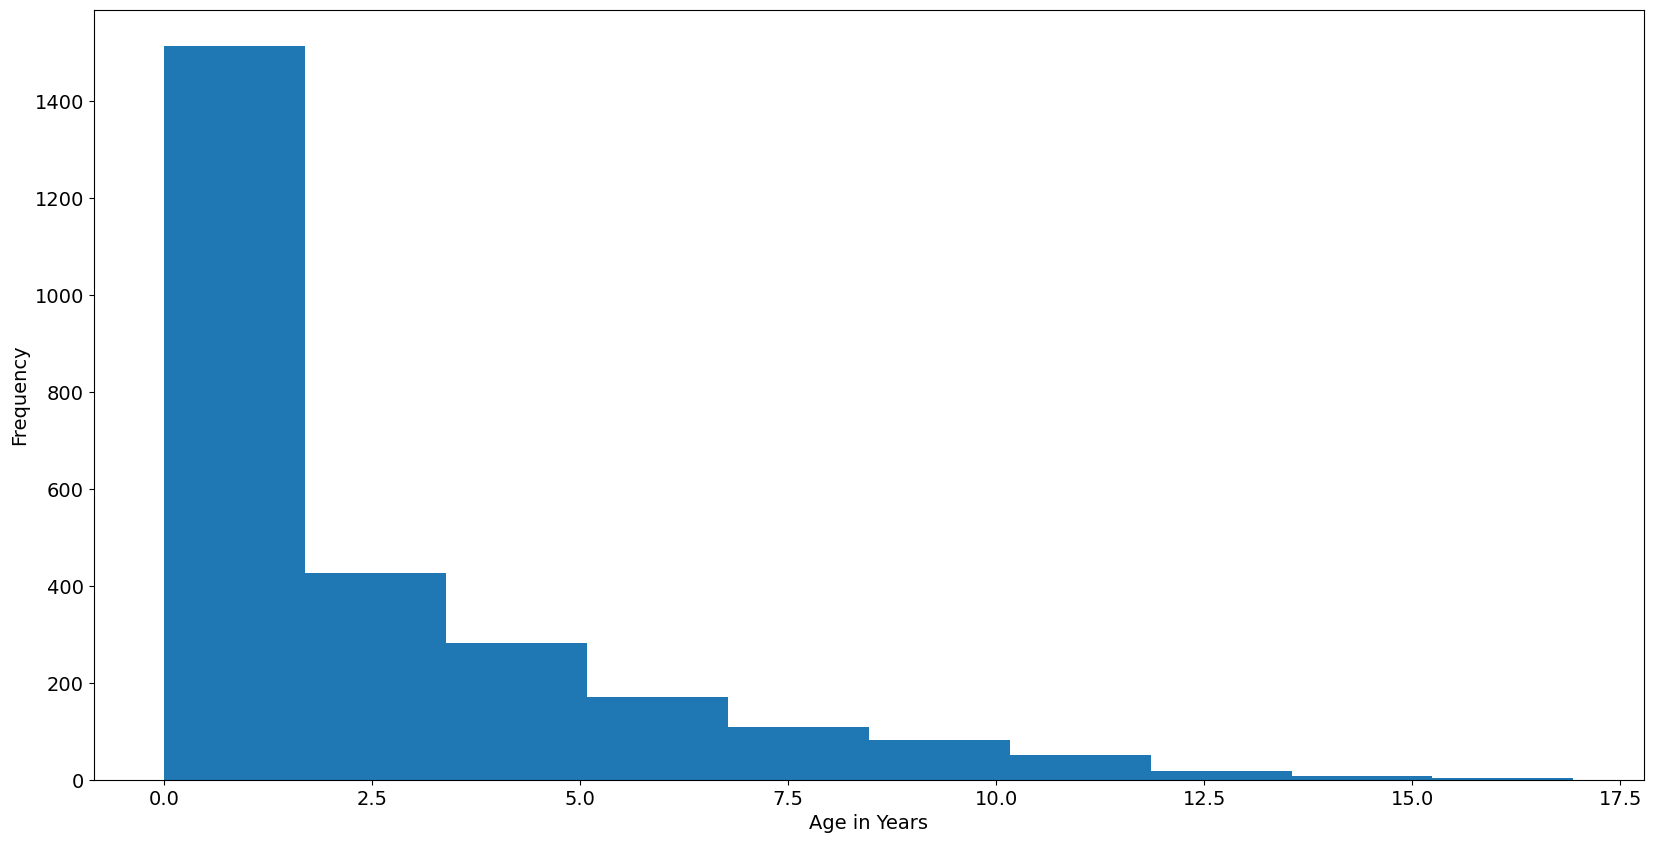

In [25]:
# Histogram of Years in Age
fig = plt.figure(figsize=(20,10))
plt.hist(df.AgeY)
plt.xlabel('Age in Years')
plt.ylabel('Frequency')
plt.show()
#fig.savefig('HistAgeY.png')

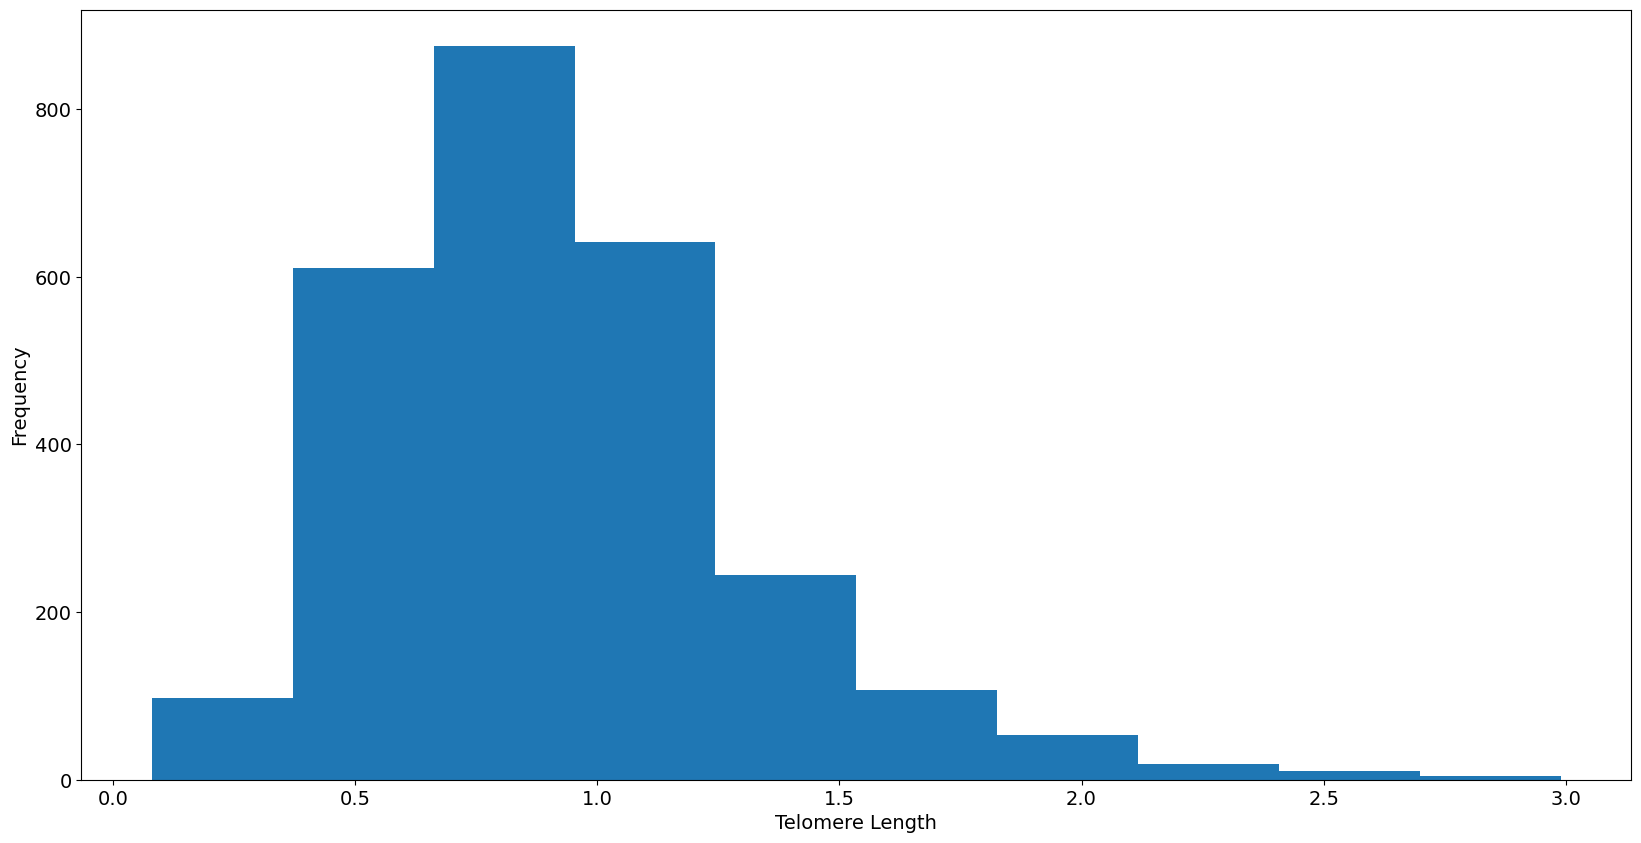

In [26]:
# Histogram of Telomere Length
fig = plt.figure(figsize=(20,10))
plt.hist(df.RTL)
plt.xlabel('Telomere Length')
plt.ylabel('Frequency')
plt.show()
#fig.savefig('HistTelo.png')


In [27]:
# add Age_CAt to the sub_df dataframe
# https://www.youtube.com/watch?v=to5xBubdcqo

df['AgeClass']= df['AgeClass'].replace({"FL":"CH"})
df['AgeClass']= df['AgeClass'].replace({"OFL":"J"})
df['AgeClass']= df['AgeClass'].replace({"SA":"A"})
df['AgeClass'].value_counts()
df.head()

,Collection_Num,BirdID,Sex,AgeY,AgeClass,BirthFPID,U_PlateID,RTL,Technician,Terr,FPID,mum,dad,MAC,PAC,BrF,BrM
0,1,5511,0,0.246575,J,103,9_3,1.06,1,10.0,104,4863,1762,3.920548,7.443836,4863,1762
1,2,5559,1,3.597260,A,103,9_1,0.52,1,77.1,122,1716,1877,7.416438,6.235616,1716,4892
2,3,5559,1,4.715068,A,103,9_28,1.07,1,77.1,125,1716,1877,7.416438,6.235616,1716,4892
3,4,5559,1,0.657534,A,103,9_2,0.99,1,111.0,104,1716,1877,7.416438,6.235616,1716,4892
4,5,5527,1,0.328767,J,103,9_3,1.02,1,131.0,104,4936,1710,3.452055,7.778082,1707,1710


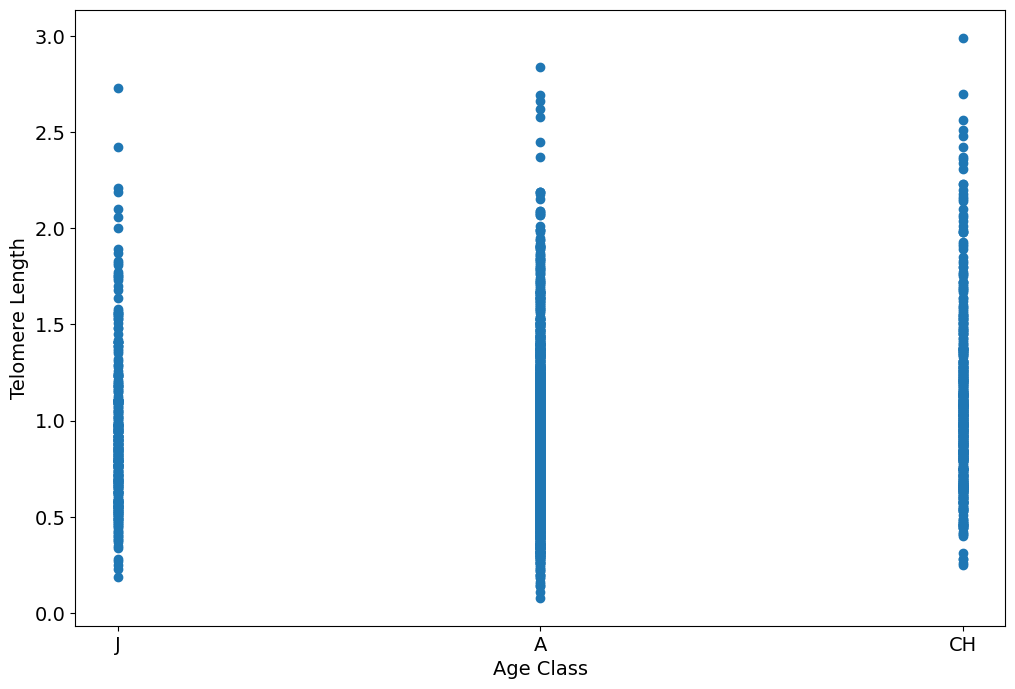

In [28]:
# plot Telomere by condenced Age Class
import matplotlib.pyplot as plt
fig = plt.figure()
plt.scatter(df.AgeClass, df.RTL)
plt.xlabel('Age Class')
plt.ylabel('Telomere Length')
plt.show()
#fig.savefig('ScattFourClass.png')

<AxesSubplot:title={'center':'RTL'}, xlabel='[AgeClass]'>

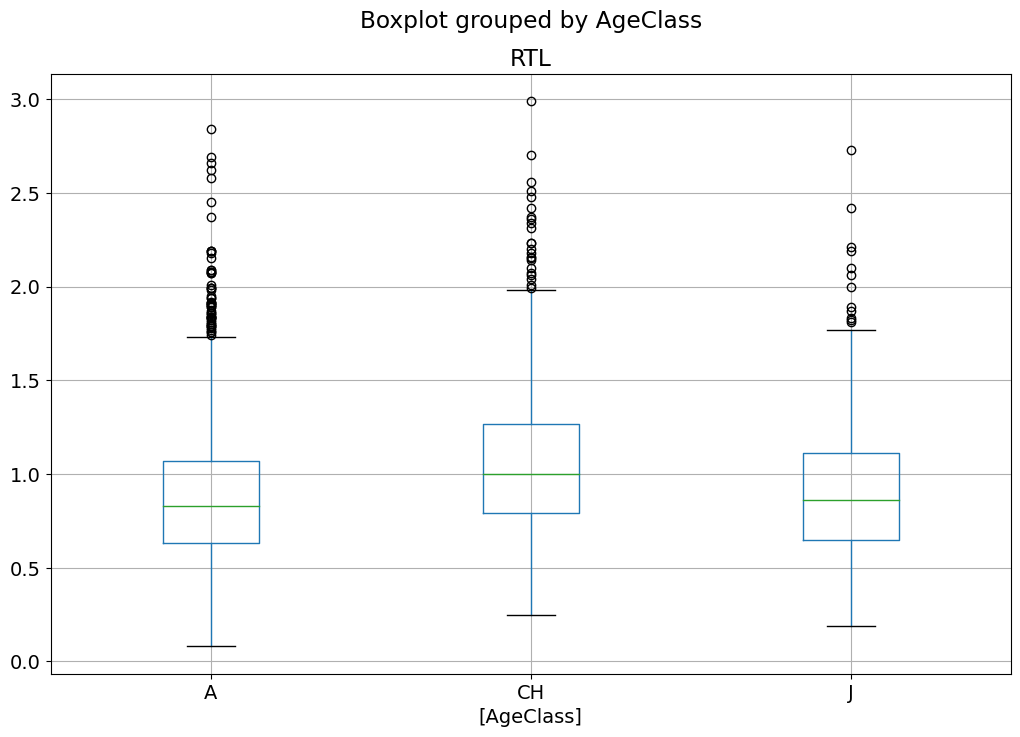

In [29]:
# Box plots by condenced Age Class
from matplotlib import pyplot as plt
# Plot boxplots of RTL by AgeClass
df.boxplot(['RTL'], by=['AgeClass'])
#plt.savefig('ThreeClass.png')

In [30]:
# Remove AgeClass status target from features data
y = df.AgeClass
X = df.drop(columns=["Collection_Num","BirdID", "Sex","AgeY", "AgeClass","BirthFPID","U_PlateID", "Technician", "Terr", "FPID", "mum", "dad", "MAC", "PAC", "BrF", "BrM"])

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [31]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.670


In [32]:
# Run model and print training and testing accuracey scores
rf_model = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {rf_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {rf_model.score(X_test_scaled, y_test)}')

Training Score: 0.7099198396793587
Testing Score: 0.6681681681681682


#### Random Forest is able to predict age class from telomere length approximaetly 67% of the time accurately. 

an example decision tree from the Random forest

In [33]:
 #Load packages
    #https://mljar.com/blog/visualize-tree-from-random-forest/
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from dtreeviz.trees import dtreeviz # will be used for tree visualization
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [34]:
# Decision Trees are stored in a list in the estimators_ attribute in the rf model.  length of the list  
# equal to n_estiamtors value.
len(rf_model.estimators_)

500

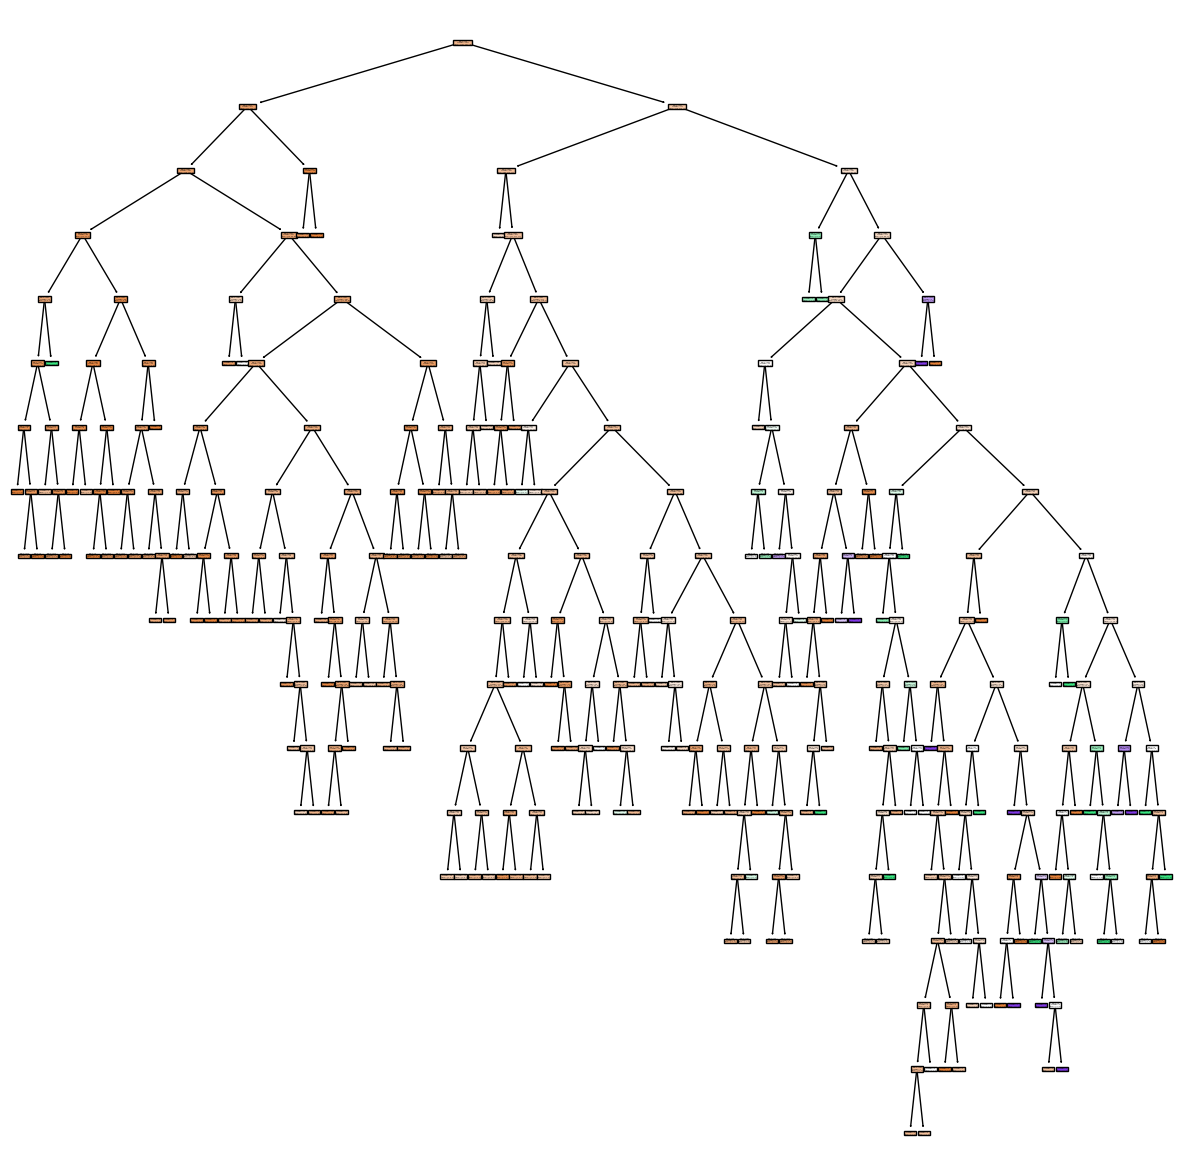

In [35]:
plt.figure(figsize=(15,15))
_ = tree.plot_tree(rf_model.estimators_[0], feature_names=X.columns, filled=True)

The tree is too large to visualize it in one figure and make it readable.

Let’s check the depth of the first tree from the Random Forest:

In [36]:
rf_model.estimators_[0].tree_.max_depth

17

first tree has max_depth=17. Other trees have similar depth. To make visualization readable it will be good to limit the depth of the tree. In MLJAR’s open-source AutoML package mljar-supervised the Decision Tree’s depth is set to be in range from 1 to 4. Let’s train the Random Forest again with max_depth=3.

In [37]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=3)

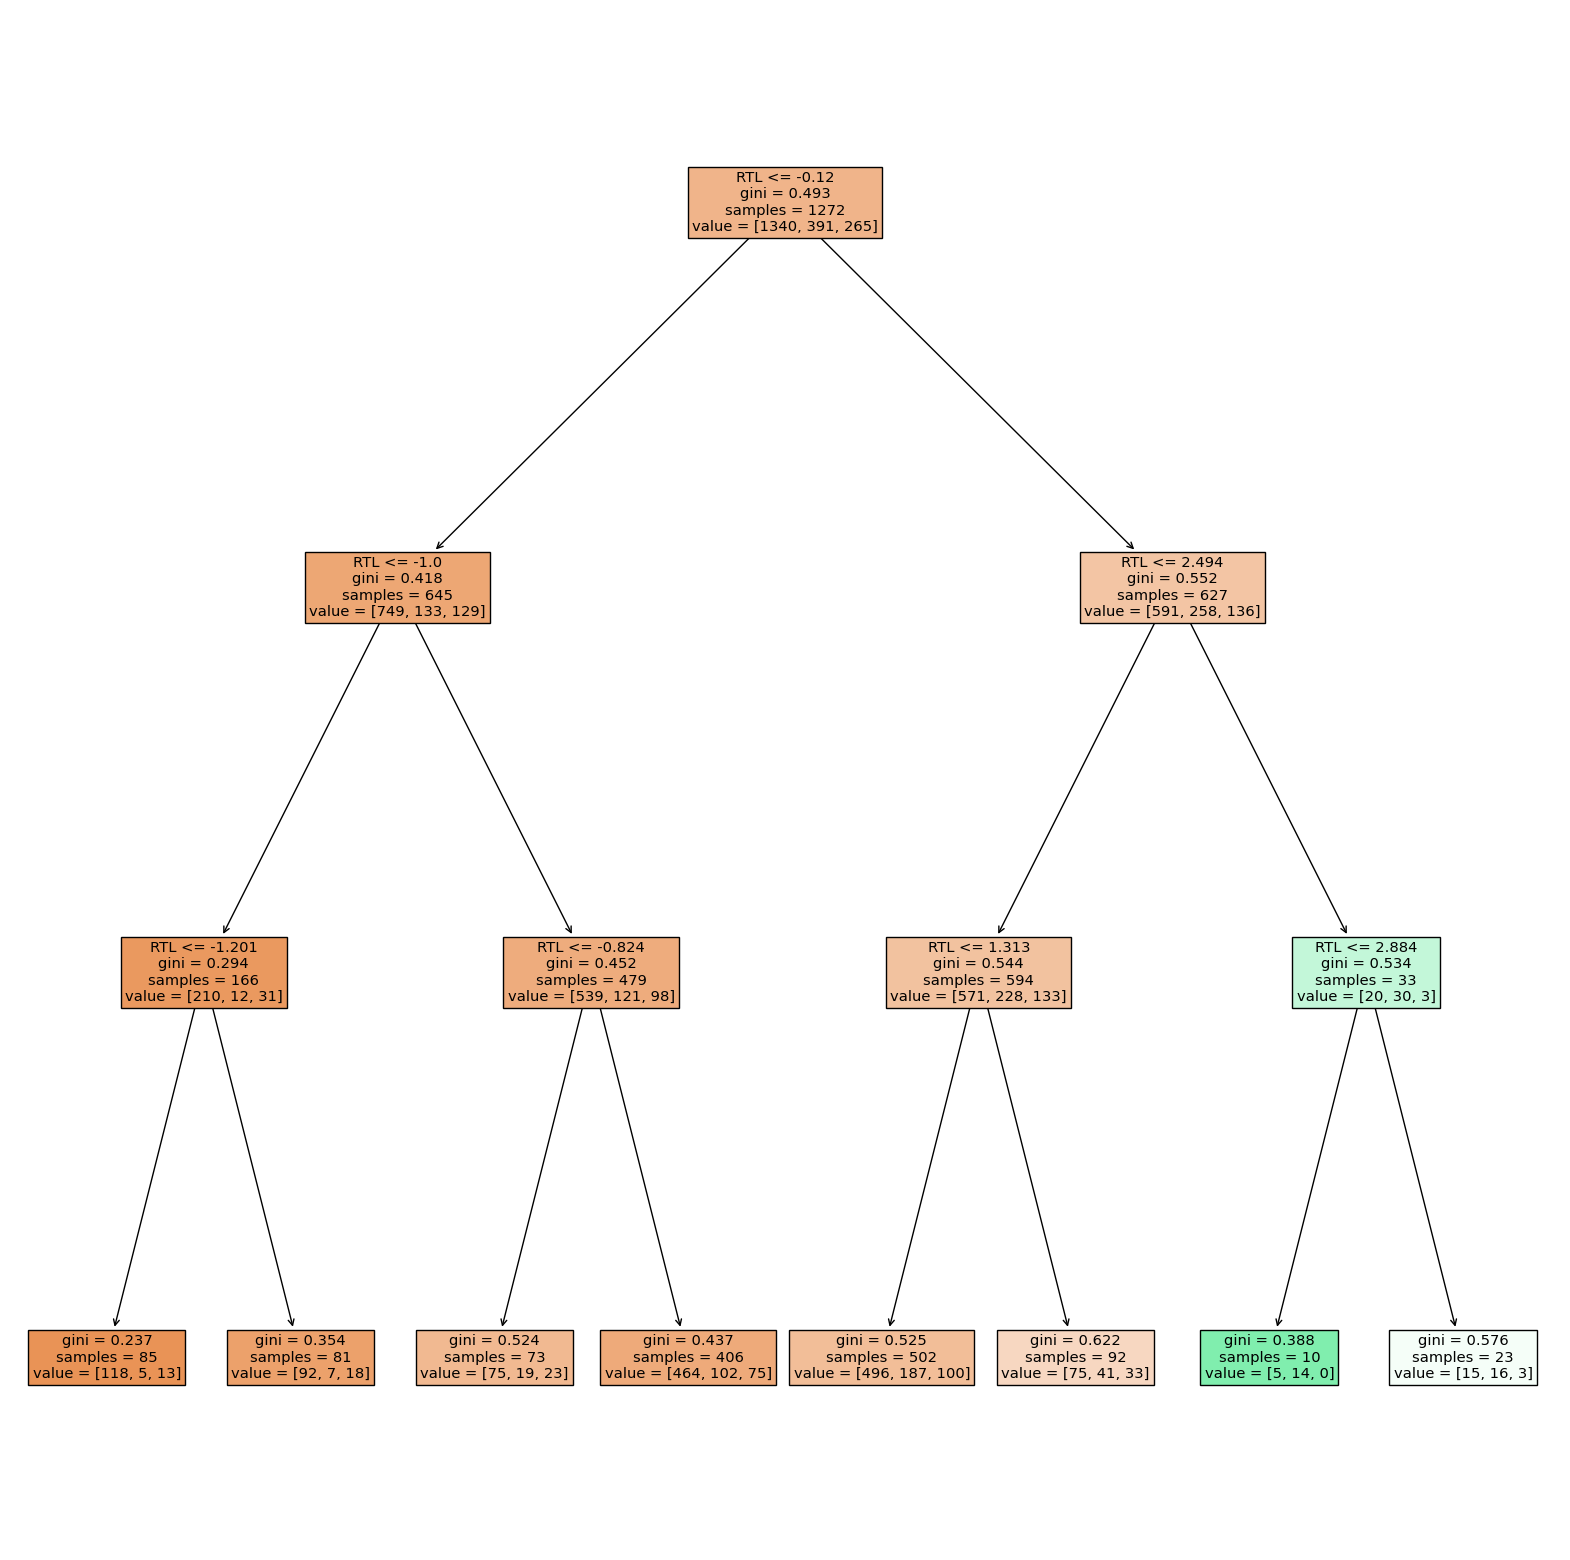

In [38]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(rf.estimators_[0], feature_names=X.columns, filled=True)

 https://www.freecodecamp.org/news/how-to-use-the-tree-based-algorithm-for-machine-learning/
 Random forest works by: 
1. The algorithm selects random samples from the dataset provided.

2. The algorithm creates a decision tree for each sample selected. Then it will get a prediction result from each decision tree.

3. Voting will then be performed for every predicted result. This is a classification model so the mode will be used. 

4. The algorithm will select prediction with the most votes as the final prediction.

https://garg-mohit851.medium.com/random-forest-visualization-3f76cdf6456f
Interpreting a Decision Tree Plot
1. Feature name
There is only one feature in this model- RTL
2. Split value — split value is decided after selecting a threshold value which gives the highest information gain for that split.
This value is selected from the range of feature i.e. best value picked from feature_val_min to feature_val_max.
3. Gini — It is basically deciding factor i.e. to select feature at next node , to pick best split value etc.
4. Samples — Number of samples remaining at that particular node.
5. Values — No of samples of each class remaining at that particular node.

